In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import linear_model as lm
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')
pd.set_option('display.max_columns', 500)

#read in data
df = pd.read_csv('c:/Users/Aaron/Desktop/bank-additional-full.csv', delimiter=';')
df['y'] = df.y.map({'no': 0, 'yes': 1})

#dictionary of column datatypes
dTypes = {k: str(v) for k, v in df.dtypes.to_dict().items()}

#bucket columns by predictor type
bank_client_data = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
campaign_data = ['contact', 'month', 'day_of_week', 'duration']
other_data = ['campaign', 'previous', 'poutcome', 'pdays']
socio_eco_data = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

def describe_new(df):
    #describe for all types of columns inluding top and no_missing
    out = df.describe(include='all')
    for c in df.columns.tolist(): 
        out.loc['type', c] = df.dtypes.to_dict()[c]
        out.loc['missing', c] = sum(df[c].isnull().values)
    out = out.T.sort_values('type').T
    return out.fillna('-')

def exploratory_plot(f):
    #a1 is current axis, dTypes is global dictionary
    #if the variable is string-type plot a countplot with a pointplot of mean_y as an overlay
    #if the variable is numeric plot a boxplot for each level of Y
    if dTypes[f]=='object':
        a2 = a1.twinx()
        sns.countplot(f, data=df, ax=a1)
        sns.pointplot(f, 'y', data=df, ci=95, linestyles='', color='black', scale=1.5, ax=a2)
        a1.set(xlabel='', ylabel='')
        a2.set(ylabel='', ylim=(0, 1))
        a1.set_xticklabels(a1.xaxis.get_majorticklabels(), rotation=45)
        a1.set_title(f, size=20)
    else:
        sns.boxplot(f, 'y', data=df, orient='h', ax=a1)
        a1.set_title(f, fontsize=20)
        a1.set(xlabel='', ylabel='Y')

    
def get_dummies(df, col):
    #get dummies, drop first, join back to dataframe, drop original column
    dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)
    df.drop(col, axis=1, inplace=True)
    return df.join(dummies)


def single_predictor_auc(col):
    #for each column, run logistic regression with only that feature, return area under curve of the model and avg prec recall
    m = lm.LogisticRegression()
    if str(df[col].dtype)!='object': 
        X = df[[col]]
    else: 
        X = pd.get_dummies(df[col], drop_first=True)
    y = df.y
    m.fit(X, y)
    return roc_auc_score(y, m.predict_proba(X)[:,-1]), average_precision_score(y, m.predict_proba(X)[:,-1])


def run_LR(df, columns, name):
    #run LR on full data set, return coefficient matrix, auc, pr score, and roc and pr plots
    print([c for c in columns])
    df = df[columns+['y']]
    need_dummy = [c for c in df.columns if dTypes[c]=='object']
    for c in need_dummy:
        df = get_dummies(df, c)
    X, y = df[[c for c in df.columns if c!='y']], df.y
    lr_model = lm.LogisticRegression()
    lr_model.fit(X, y)
    prediction = lr_model.predict_proba(X)[:, -1]
    odds = [np.exp(i) for i in lr_model.coef_[0]]
    absv = [abs(i) for i in lr_model.coef_[0]]
    coef_matrix = pd.DataFrame(zip(X.columns.tolist(), list(lr_model.coef_[0]), odds, absv), columns=['feature', 'coef', 'odds', 'absv']).sort_values('absv', ascending=False).drop('absv', axis=1)
    print(coef_matrix)
    fpr, tpr, _ = roc_curve(y, prediction)
    prec, rec, _ = precision_recall_curve(y, prediction)
    auc = str(round(roc_auc_score(y, prediction), 2))
    avg_prec = str(round(average_precision_score(y, prediction), 2))
    fig, axs = plt.subplots(1, 2, figsize=(18, 3))
    fig.suptitle(name, y=1.1, fontsize=15)
    axs[0].plot(fpr, tpr, linewidth=2)
    axs[0].plot([0, 1], [0, 1], linestyle='--', color='k')
    axs[0].set_xlabel('fpr')
    axs[0].set_ylabel('tpr')
    axs[0].set_title('ROC Curve;   AUC: %s'%auc, fontsize=15)
    axs[1].plot(rec, prec, linewidth=2)
    axs[1].set_xlabel('rec')
    axs[1].set_ylabel('prec')
    axs[1].set_title('Precision Recall Curve;   Avg Prec: %s'%avg_prec, fontsize=15)
    plt.show()

In [5]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

Aaron Cohen
Final Project #4

## Variables:
#### bank client data:
    1 - age (numeric)
    2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    5 - default: has credit in default? (categorical: 'no','yes','unknown')
    6 - housing: has housing loan? (categorical: 'no','yes','unknown')
    7 - loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
    8 - contact: contact communication type (categorical: 'cellular','telephone') 
    9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
    11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### other attributes:
    12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    14 - previous: number of contacts performed before this campaign and for this client (numeric)
    15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#### social and economic context attributes
    16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
    17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
    18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
    19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
    20 - nr.employed: number of employees - quarterly indicator (numeric)

#### y - has the client subscribed a term deposit? (binary: 'yes','no')



In [6]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [7]:
describe_new(df)

,age,previous,pdays,campaign,duration,y,nr.employed,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,housing,loan,contact,month,day_of_week,education,marital,job,poutcome,default
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,-,-,-,-,-,-,-,-,-,-,-,3,3,2,10,5,8,4,12,3,3
top,-,-,-,-,-,-,-,-,-,-,-,yes,no,cellular,may,thu,university.degree,married,admin.,nonexistent,no
freq,-,-,-,-,-,-,-,-,-,-,-,21576,33950,26144,13769,8623,12168,24928,10422,35563,32588
mean,40.0241,0.172963,962.475,2.56759,258.285,0.112654,5167.04,0.0818855,93.5757,-40.5026,3.62129,-,-,-,-,-,-,-,-,-,-
std,10.4212,0.494901,186.911,2.77001,259.279,0.316173,72.2515,1.57096,0.57884,4.6282,1.73445,-,-,-,-,-,-,-,-,-,-
min,17,0,0,1,0,0,4963.6,-3.4,92.201,-50.8,0.634,-,-,-,-,-,-,-,-,-,-
25%,32,0,999,1,102,0,5099.1,-1.8,93.075,-42.7,1.344,-,-,-,-,-,-,-,-,-,-
50%,38,0,999,2,180,0,5191,1.1,93.749,-41.8,4.857,-,-,-,-,-,-,-,-,-,-
75%,47,0,999,3,319,0,5228.1,1.4,93.994,-36.4,4.961,-,-,-,-,-,-,-,-,-,-


# Exploratory Analysis- 
    Categoricals: Bar Plot of Freq & Mean Y by Level
    Numeric: Boxplots for Y=0 and Y=1

In [8]:
keep = []

## Bank Client Data- 

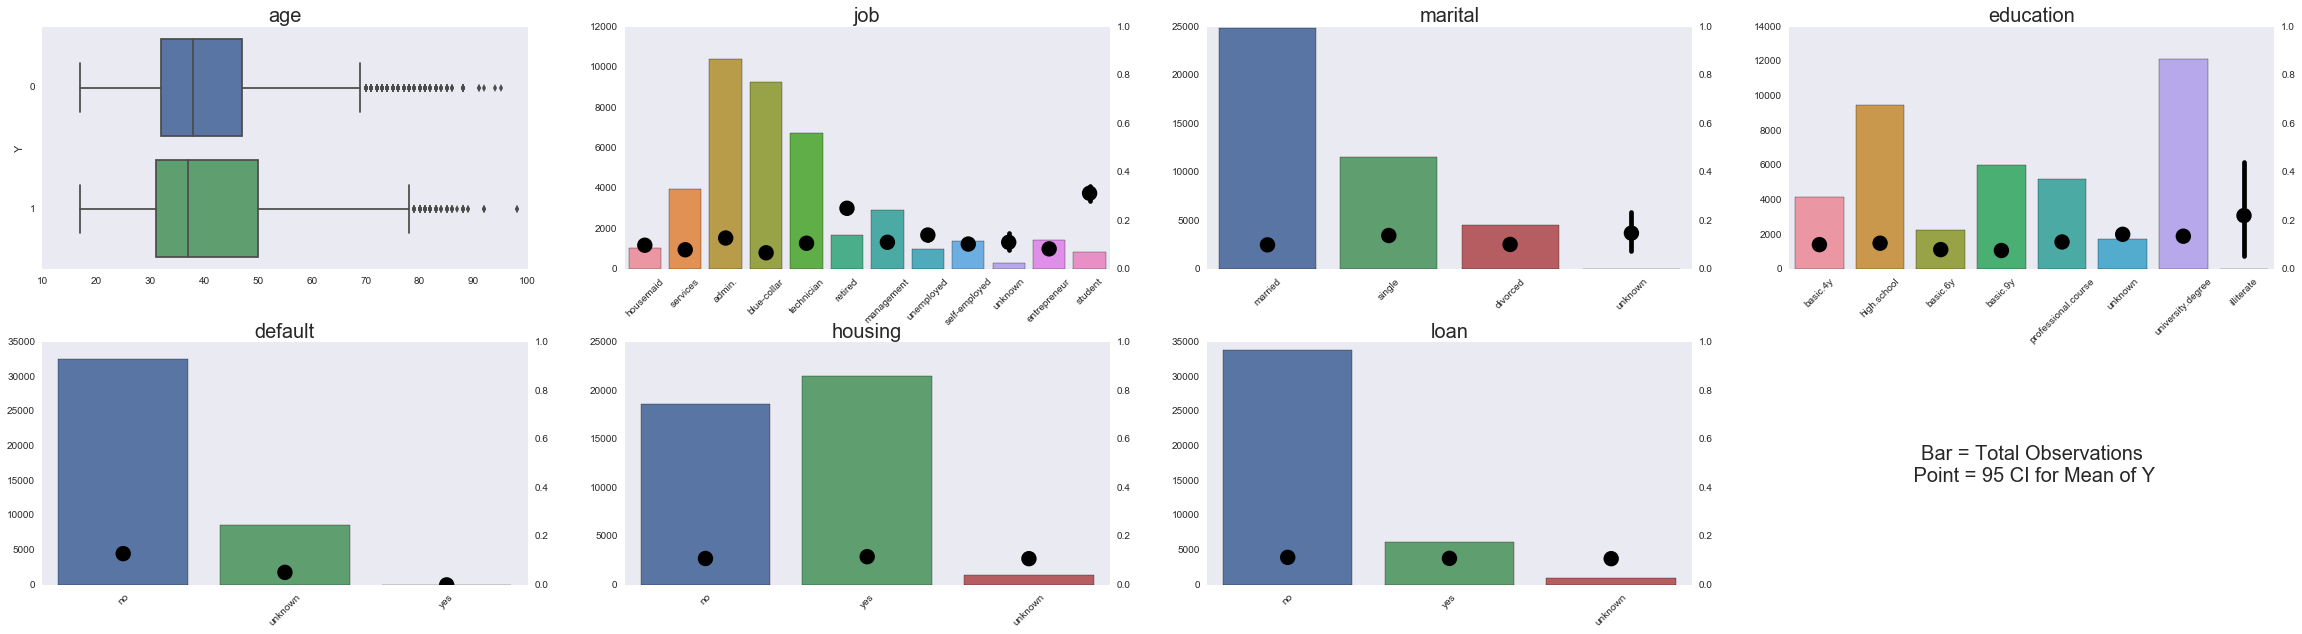

In [9]:
no_columns = 4
fig, axs = plt.subplots(2, no_columns, figsize=(40, 10))
        
for n, f in enumerate(bank_client_data):
    if n<no_columns: r, c = 0, n
    else: r, c = 1, n - no_columns
    a1 = axs[r,c]
    exploratory_plot(f)
    
fig.delaxes(axs[-1,-1]) 
axs[0,-1].set_xlabel('Bar = Total Observations\n Point = 95 CI for Mean of Y', size=20, labelpad=100)
plt.subplots_adjust(wspace=.2, hspace=.3)
plt.show()

#### Age

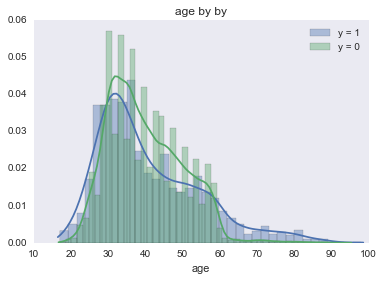

In [10]:
sns.distplot(df[df.y==1].age, label='y = 1')
sns.distplot(df[df.y==0].age, label='y = 0')
plt.legend()
plt.title('age by by')

    - Age might be a good predictor, y=1 contains older people.

#### Job

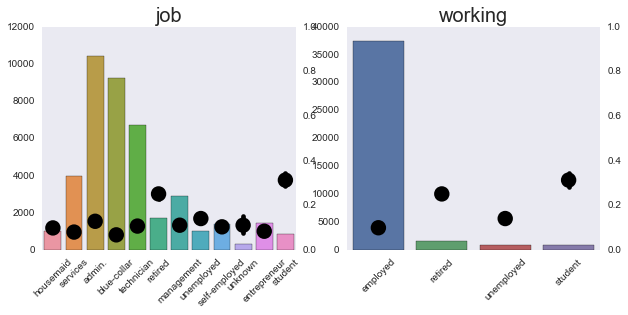

In [11]:
#consoldate job columns into working or not
f = lambda x: 'employed' if x not in ['unemployed', 'student', 'retired'] else x
df['working'] = df.job.apply(f)
dTypes = {k: str(v) for k, v in df.dtypes.to_dict().items()}
_, axs = plt.subplots(1, 2, figsize=(10, 4))
a1 = axs[0]
exploratory_plot('job')
a1 = axs[1]
exploratory_plot('working')

    - Working may be a better predictor than Job, as mean y does not seem to depend on type of Job as much as working status

In [12]:
keep += ['working', 'age']

## Campaign Data

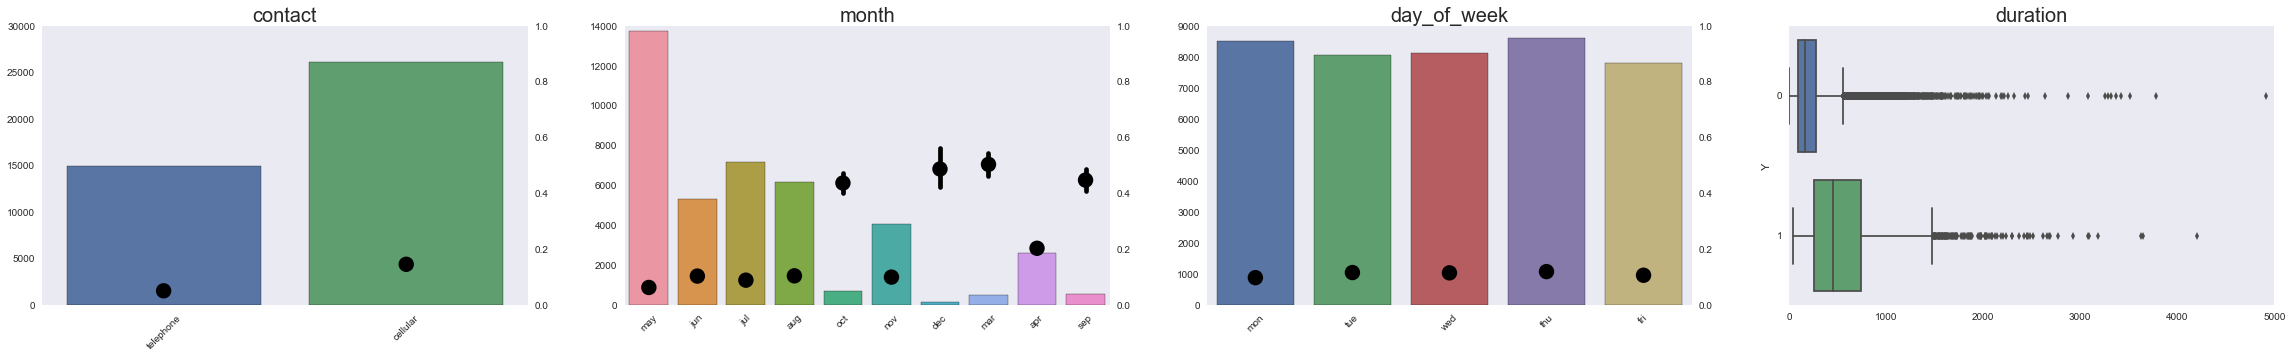

In [13]:
no_columns = 4
fig, axs = plt.subplots(1, no_columns, figsize=(40, 5))

for n, f in enumerate(campaign_data):
    a1 = axs[n]
    exploratory_plot(f)
        
plt.subplots_adjust(wspace=.2, hspace=.3)
plt.show()

    - Month may be a good predictor

#### Do cell phones lead to longer or shorter calls than home phones?

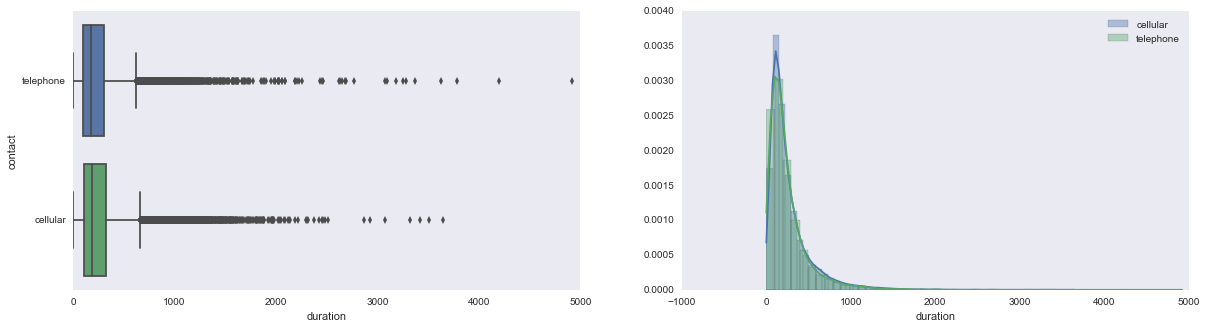

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot('duration', 'contact', data=df, orient='h', ax=axs[0], palette='deep')
sns.distplot(df[df.contact=='cellular'].duration, label='cellular', ax=axs[1])
sns.distplot(df[df.contact=='telephone'].duration, label='telephone', ax=axs[1])
axs[1].legend(loc='best')

    - Contact may be a good predictor, as cell phones have a higher mean of y and this is not due to interaction with duration

In [15]:
keep += ['contact', 'month']

## Socio Eco Data

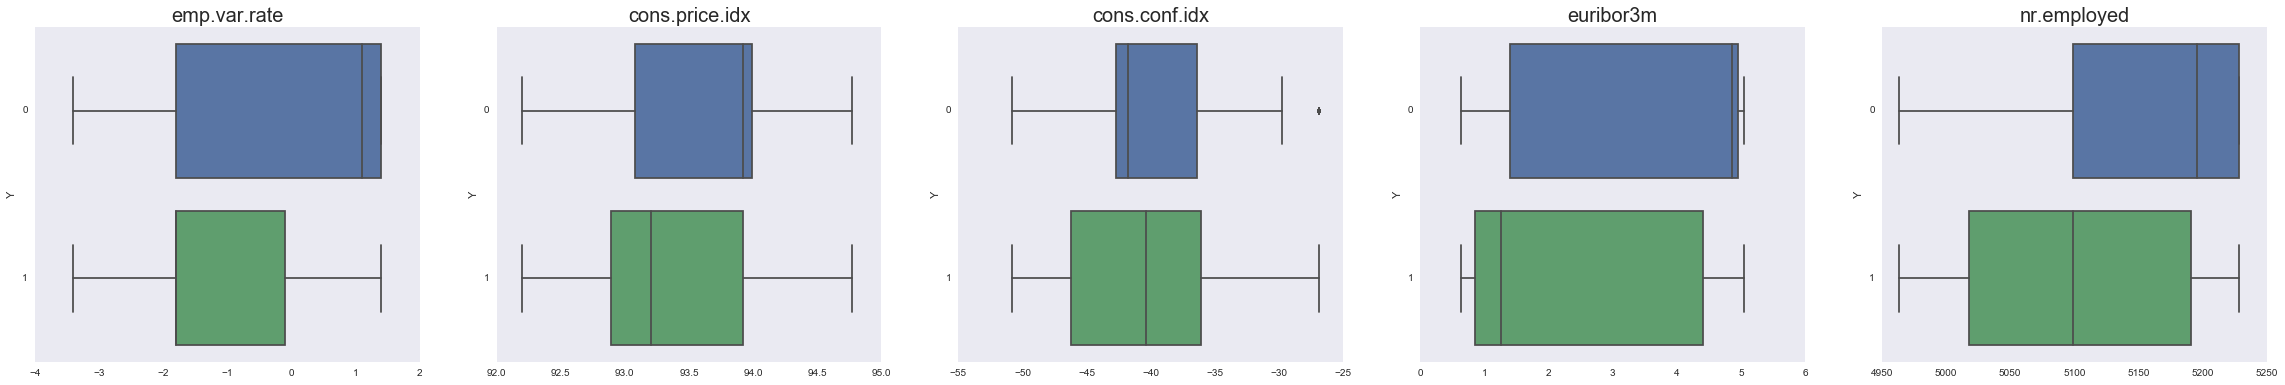

In [16]:
no_columns = 5
fig, axs = plt.subplots(1, no_columns, figsize=(40, 6))

for n, f in enumerate(socio_eco_data):
    a1 = axs[n]
    exploratory_plot(f)
        
plt.subplots_adjust(wspace=.2, hspace=.3)
plt.show()

    - emp.var.rate and nr.employed look like good predictors, however many of these variables may be highly correlated

#### Correlation between all Socio Eco Data

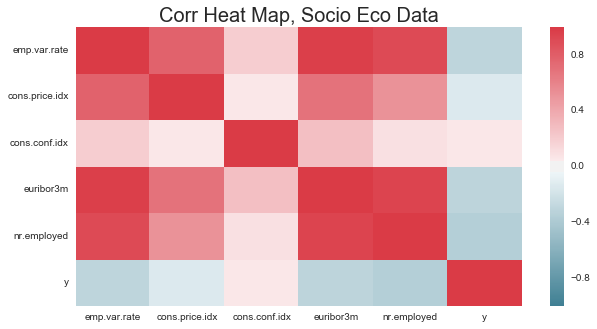

In [17]:
plt.figure(figsize=(10, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df[socio_eco_data+['y']].corr(), cmap=cmap)
plt.title('Corr Heat Map, Socio Eco Data', fontsize=20)
plt.show()

    - Everything is highly correlated with the exception of cons.conf.idx
    - Keep euribor3m and cons.conf.idx

In [18]:
keep += ['cons.conf.idx', 'euribor3m']

## Other Data

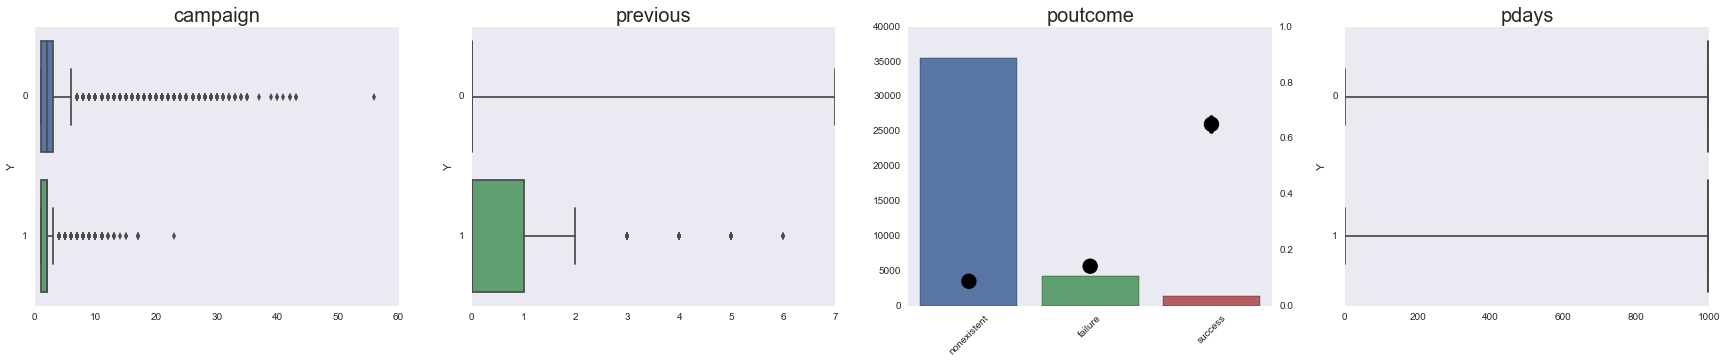

In [19]:
no_columns = 4
fig, axs = plt.subplots(1, no_columns, figsize=(30, 5))

for n, f in enumerate(other_data):
    a1 = axs[n]
    exploratory_plot(f)
        
plt.subplots_adjust(wspace=.2, hspace=.3)
plt.show()

    - Most of pdays values are unknown, throw it out
    - Previous Outcome is a good predictor, if they have previously converted they are likely to convert again.

#### Campaign

(0, 10)

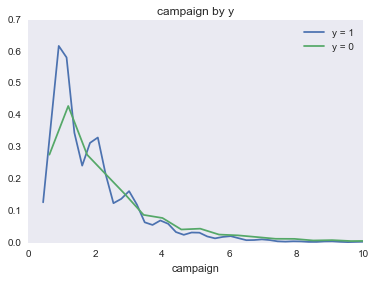

In [20]:
sns.distplot(df[df.y==1].campaign, label='y = 1', hist=False)
sns.distplot(df[df.y==0].campaign, label='y = 0', hist=False)
plt.legend()
plt.title('campaign by y')
plt.xlim(0, 10)

    - Campaign could be a good predictor, number of times client has been contacted for this campaign. People usually convert within the first couple of calls.

#### Previous

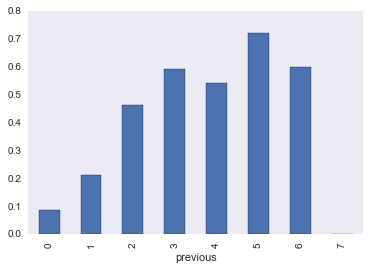

In [21]:
df.groupby('previous').y.mean().plot(kind='bar')

    - Previous Calls could be a good predictor, first time call recipients are less likely to convert for this campaign.

In [22]:
keep += ['previous', 'poutcome', 'campaign']

## Mean of Y by Month / Day

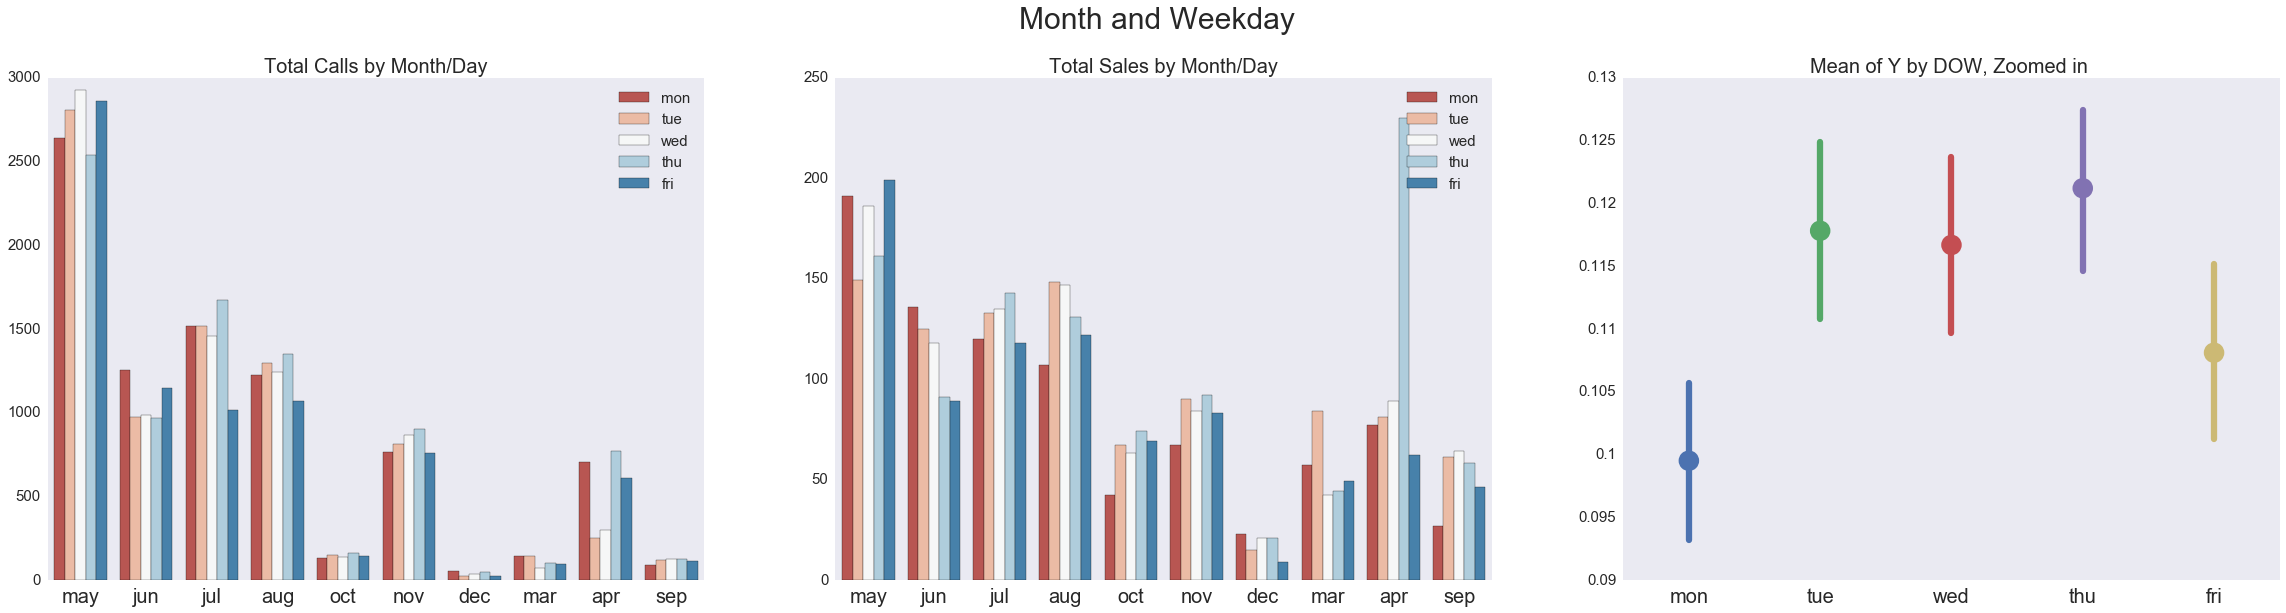

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(40, 9))
fig.suptitle('Month and Weekday', fontsize=30, y=1.01, x=.51)

#first chart for whole df (calls), second for only where y=1 (sales)
dPlot = {0: [df, 'Total Calls by Month/Day'], 1: [df[df.y==1], 'Total Sales by Month/Day']}

for k, v in dPlot.items():
    a1 = axs[k]
    sns.countplot('month', hue= 'day_of_week', data=v[0], palette='RdBu', ax=a1)
    a1.set(xlabel='', ylabel='')
    a1.set_title(v[1], fontsize=20)
    a1.set_xticklabels(a1.get_xticklabels(), fontsize=20)
    a1.set_yticklabels([int(i) for i in a1.get_yticks()], fontsize=15)
    a1.legend(loc='upper right', fontsize=15, markerscale=3)

sns.pointplot('day_of_week', 'y', data=df, ci=95, linestyles='', scale=2, palette='deep', ax=axs[2])
axs[2].set(xlabel='', ylabel='')
axs[2].set_title('Mean of Y by DOW, Zoomed in ', fontsize=20)
axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=20)
axs[2].set_yticklabels(axs[2].get_yticks(), fontsize=15)

plt.show()

    - Good to include Day along with Month, as there seems to be interraction, and the p(y) is different for days in the middle of the week

In [24]:
keep += ['day_of_week']

## Histogram for all Numeric Variables

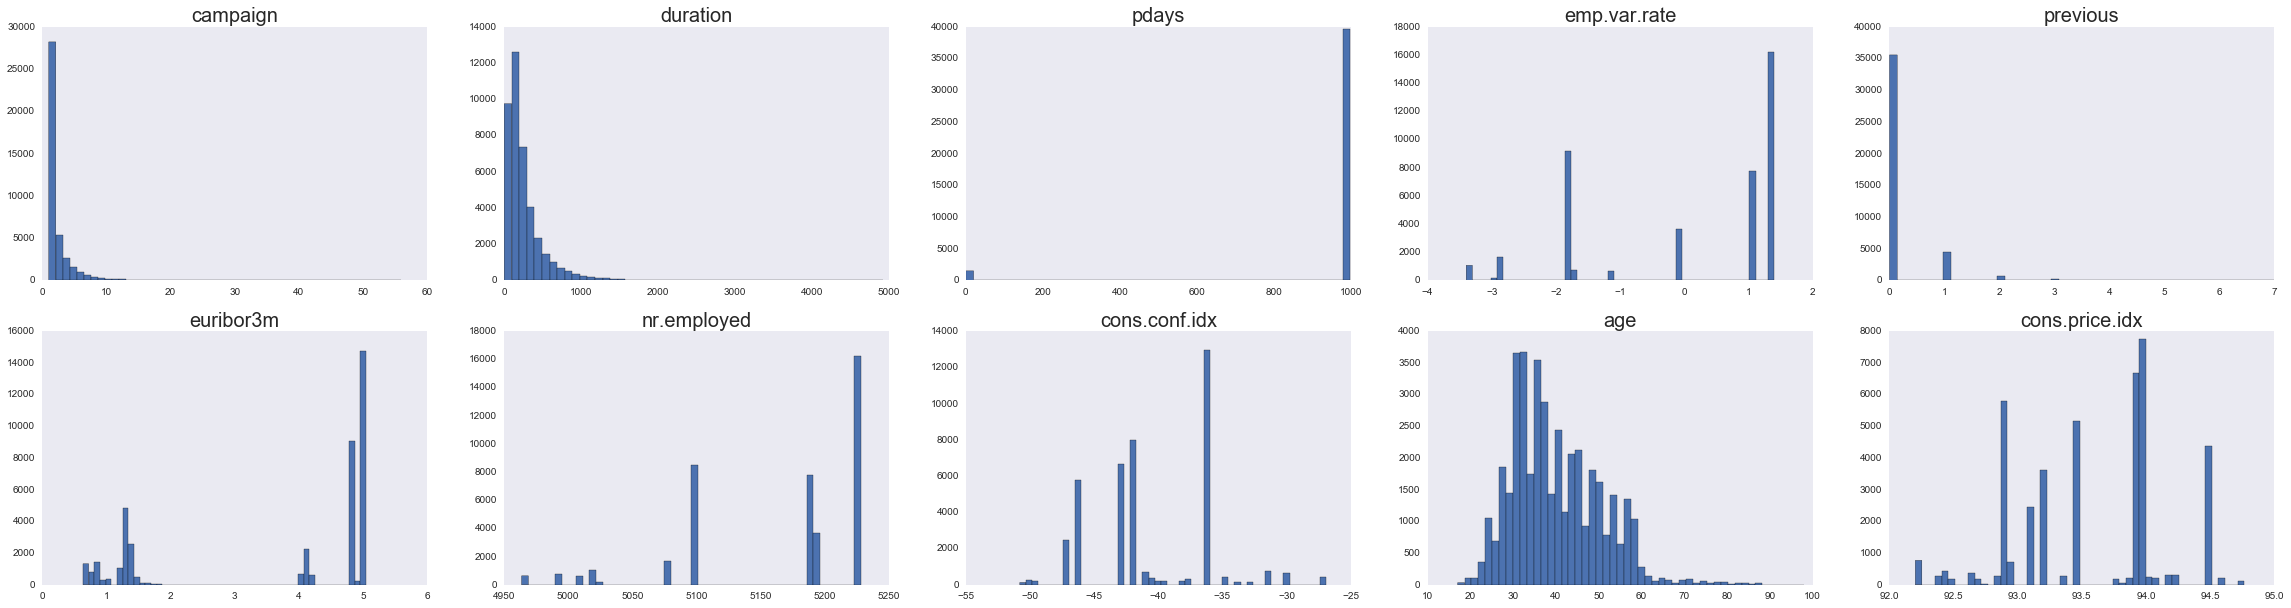

In [25]:
no_columns = 5

fig, axs = plt.subplots(2, no_columns, figsize=(40, 10))

for n, f in enumerate([k for k, v in dTypes.items() if v!='object' and k!='y']):
    if n < no_columns: 
        r,c = 0, n
    else:
        r,c = 1, n - no_columns
    a1 = axs[r,c]
    a1.hist(df[f], 50)
    a1.set_title(f, fontsize=20)
    a1.set(xlabel='', ylabel='')

plt.subplots_adjust(wspace=.2, hspace=.2)

## Mean of Y across all groups of Categorical Variables

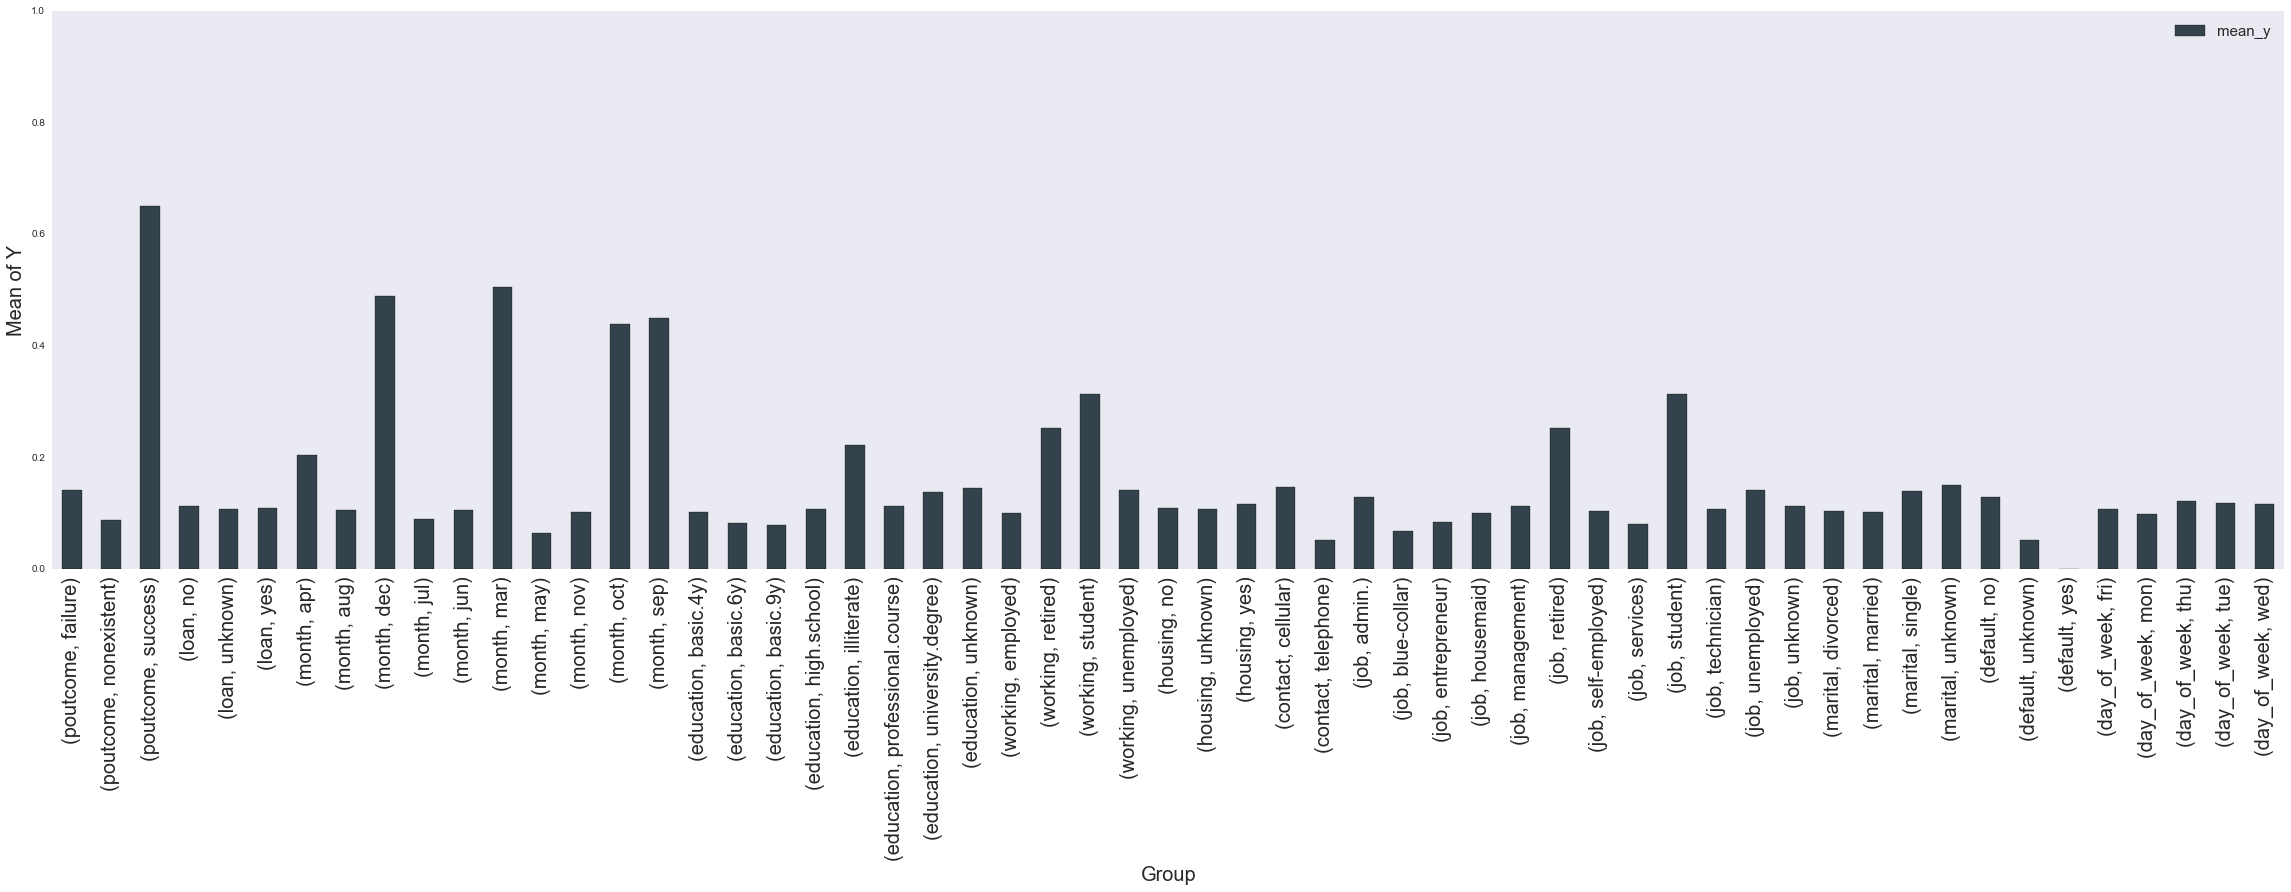

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(40, 10))
sns.set_palette('Blues_d', 10)

out = []
for c in [k for k, v in dTypes.items() if v=='object']:
    for g in df.groupby(c):
        mean_y = sum(g[1].y) / float(len(g[1]))
        out.append([c, g[0], mean_y])
        
pd.DataFrame(out, columns=['variable', 'level', 'mean_y']).set_index(['variable', 'level']).plot(kind='bar', ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), fontsize=20)
axs.set_ylim([0, 1])
plt.legend(loc='upper right', markerscale=3, fontsize=15)
plt.xlabel('Group', fontsize=20)
plt.ylabel('Mean of Y', fontsize=20)
plt.show()

## Corr map for Numeric Variables to Keep

In [27]:
keep

['working',
 'age',
 'contact',
 'month',
 'cons.conf.idx',
 'euribor3m',
 'previous',
 'poutcome',
 'campaign',
 'day_of_week']

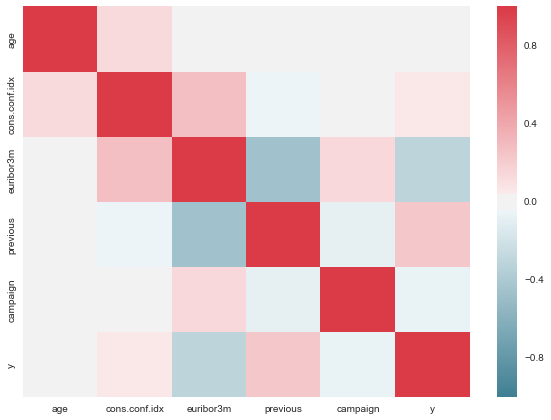

In [28]:
plt.figure(figsize=(10, 7))
sns.heatmap(df[[i for i in keep if str(df[i].dtype)!='object']+['y']].corr(), cmap=cmap)

## Make changes to existing predictors based on Exploratory Analysis

### Transform age? campaign?

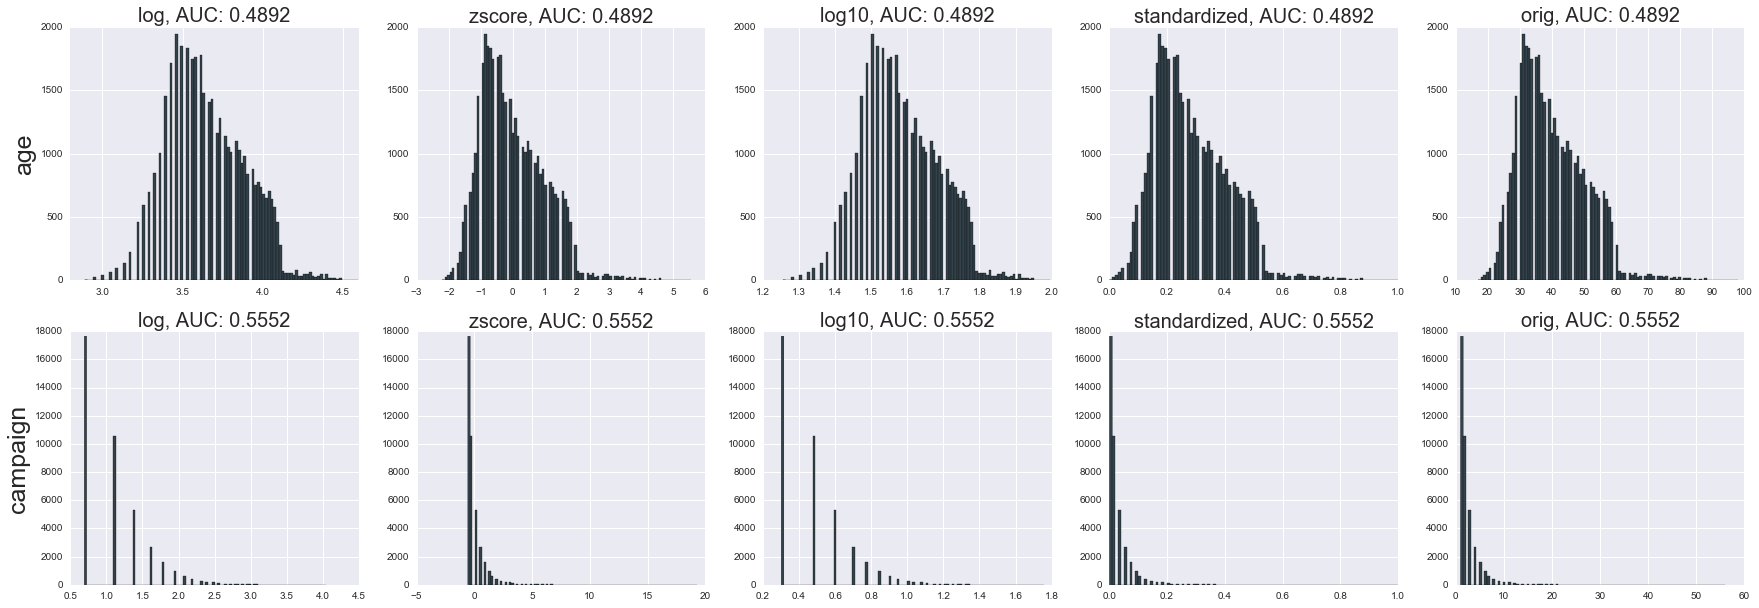

In [29]:
sns.set_style('darkgrid')
_, axs = plt.subplots(2, 5, figsize=(30, 10))


def plot_transformation(col, row):
    mu, stdev = df[col].mean(), df[col].std()
    mn, mx = df[col].min(), df[col].max()
    plots = {'orig': df[col].copy(),
            'zscore': [(x - mu) / float(stdev) for x in df[col]],
            'standardized': [(x - mn) / float(mx - mn) for x in df[col]],
            'log': [np.log(x+1) for x in df[col]],
            'log10': [np.log10(x+1) for x in df[col]]
            }
    for n, tr in enumerate(plots):
        axs[row, n].hist(
            plots[tr], bins=100)
        X, y = pd.DataFrame(plots[tr]), df.y
        m = lm.LogisticRegression()
        m.fit(X, y)
        #axs[row, col].set_title(tr + ', Accuracy: ' + str(round(m.score(X, y), 2)), fontsize=20)
        axs[row, n].set_title(tr + ', AUC: ' + str(round(roc_auc_score(y, m.predict_proba(X)[:, -1,]), 4)), fontsize=20)
        axs[row, 0].set_ylabel(col, fontsize=25)

plot_transformation('age', 0)
plot_transformation('campaign', 1)
plt.show()

# Modeling

#### Single Predictor Model Scoring

In [30]:
pd.DataFrame.from_dict({col: single_predictor_auc(col) for col in df.columns}, orient='index').sort_values(0, ascending=False).rename(columns={0: 'AUC', 1: 'Avg PR'})

,AUC,Avg PR
y,1.000000,1.000000
duration,0.818446,0.394057
nr.employed,0.748997,0.373564
euribor3m,0.743478,0.343725
emp.var.rate,0.716753,0.306221
month,0.658107,0.275499
poutcome,0.613842,0.347215
cons.price.idx,0.610562,0.229657
job,0.610272,0.202494
contact,0.610239,0.498436


    - As single predictors, Socio Eco metrics give us the best AUC. Duration, as expected, performs excellently.

#### Only Columns we are keeping (Keep Model)

['working', 'age', 'contact', 'month', 'cons.conf.idx', 'euribor3m', 'previous', 'poutcome', 'campaign', 'day_of_week']
                 feature      coef      odds
19      poutcome_success  1.834104  6.259522
13             month_mar  1.055378  2.873061
14             month_may -0.704750  0.494232
18  poutcome_nonexistent  0.665726  1.945904
2              euribor3m -0.483544  0.616594
10             month_dec  0.409064  1.505408
11             month_jul  0.379047  1.460892
5        working_retired  0.358757  1.431549
16             month_oct  0.335236  1.398271
6        working_student  0.321469  1.379152
12             month_jun  0.316079  1.371739
8      contact_telephone -0.271193  0.762469
3               previous  0.225286  1.252681
20       day_of_week_mon -0.195291  0.822595
17             month_sep  0.142513  1.153168
23       day_of_week_wed  0.140912  1.151324
15             month_nov -0.092579  0.911578
9              month_aug -0.074309  0.928385
21       day_of_week_thu 

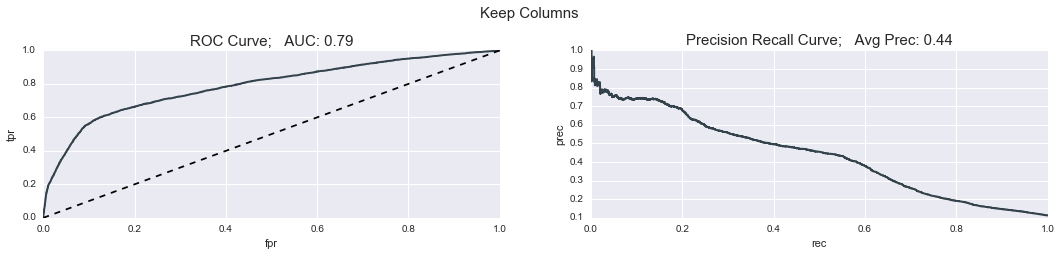

In [31]:
run_LR(df, keep, 'Keep Columns')

    - This model comes close to the AUC of duration (benchmark), and has a better PR score.
    - Using a single Socio Eco predictor will give you comparable AUC, but not as good PR score.
    - If you have previously converted, you are more than 6 times more likely to convert on this call.

#### Compare to using All Data

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'working']
                          feature      coef      odds
42                      month_may -0.497401  0.608109
5                  cons.price.idx  0.317692  1.373953
36              contact_telephone -0.276835  0.758179
4                    emp.var.rate -0.193439  0.824120
39                      month_jul  0.190791  1.210206
3                        previous -0.186976  0.829464
50           poutcome_nonexistent  0.177454  1.194174
41                      month_mar  0.154842  1.167473
7                       euribor3m -0.146751  0.863509
30                default_unknown -0.146733  0.863525
46                day_of_week_mon -0.133094  0.875382
9                 job_blue-collar -0.131914  0.876416
28    education_university.degree  0.103865  1.109450
21   

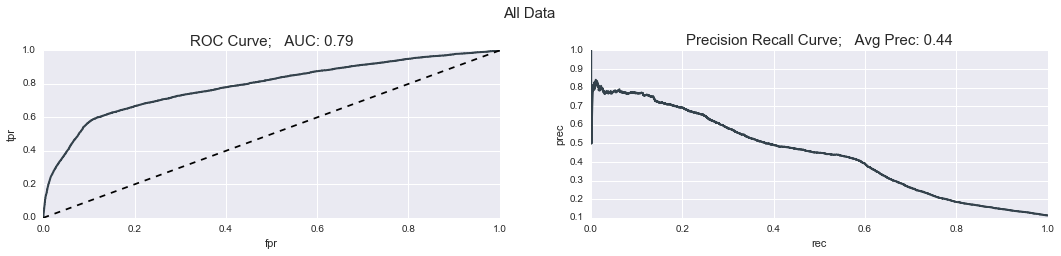

In [32]:
run_LR(df, [p for p in df.columns if p!='duration' and p!='y'], 'All Data')

    - Keep Model is just as good

#### Compare to using all Eco Data

['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
          feature      coef      odds
1  cons.price.idx  0.311202  1.365064
3       euribor3m -0.245214  0.782537
0    emp.var.rate -0.197030  0.821166
2   cons.conf.idx  0.042661  1.043584
4     nr.employed -0.005604  0.994412


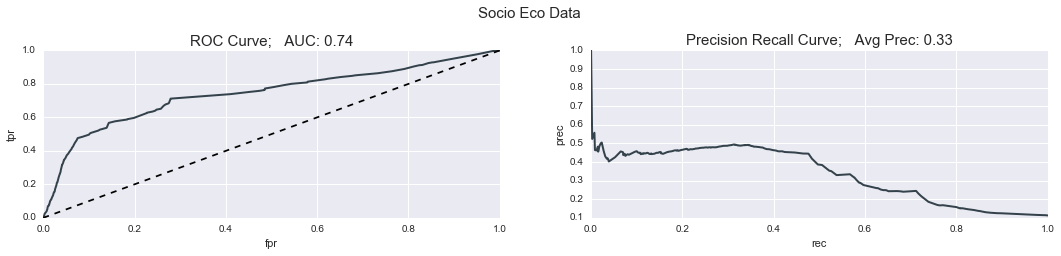

In [33]:
run_LR(df, socio_eco_data, 'Socio Eco Data')

    - Keep Model has better ROC and PR

## Run LR and KNN with Keep predictors, Cross Validate

In [34]:
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation

In [35]:
#keep only importand predictors, run LR / KNN
df_model = df[keep + ['y']]

df_model = get_dummies(df_model, [i for i in df_model.columns if df[i].dtype=='object'])

X, y = df_model[[c for c in df_model.columns if c!='y']], df_model.y

### LR

In [36]:
params = {'C': float(1)/np.arange(1, 5000, 100),
          'fit_intercept': [True, False]}

kf = cross_validation.KFold(len(X), n_folds=5, shuffle=True)

gs = GridSearchCV(lm.LogisticRegression(penalty='l2'), 
                  param_grid=params,
                  cv=kf, 
                  scoring='roc_auc')
gs.fit(X,y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=41188, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e+00,   9.90099e-03,   4.97512e-03,   3.32226e-03,
         2.49377e-03,   1.99601e-03,   1.66389e-03,   1.42653e-03,
         1.24844e-03,   1.10988e-03,   9.99001e-04,   9.08265e-04,
         8.32639e-04,   7.68640e-04,   7.13776e-04,   6.66223e-04,
         6.2461...  2.17344e-04,   2.12721e-04,
         2.08290e-04,   2.04040e-04]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

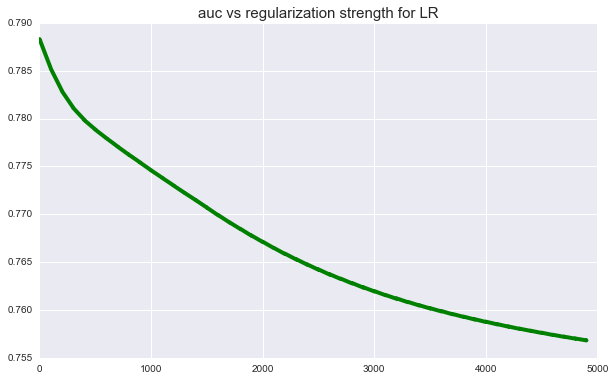

In [37]:
_, axs = plt.subplots(1, 1, figsize=(10, 6))
sns.set_style('darkgrid')
axs.plot(1/np.array([g[0]['C'] for g in gs.grid_scores_]), [g[1] for g in gs.grid_scores_], color='green', linewidth=4.0)
axs.set_title('auc vs regularization strength for LR', fontsize=15)
plt.show()

In [38]:
print gs.best_params_
print gs.best_score_

{'C': 1.0, 'fit_intercept': False}
0.788317018295


### KNN

In [39]:
params = {'n_neighbors': range(1, 25),
          'weights': ['uniform', 'distance']}

cv = cross_validation.KFold(len(X), n_folds=5, shuffle=True)


gs = GridSearchCV(neighbors.KNeighborsClassifier(), 
                  param_grid=params,
                  cv=cv, 
                  scoring='roc_auc')
gs.fit(X,y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=41188, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [40]:
print gs.best_params_
print gs.best_score_

{'n_neighbors': 22, 'weights': 'uniform'}
0.766776481113


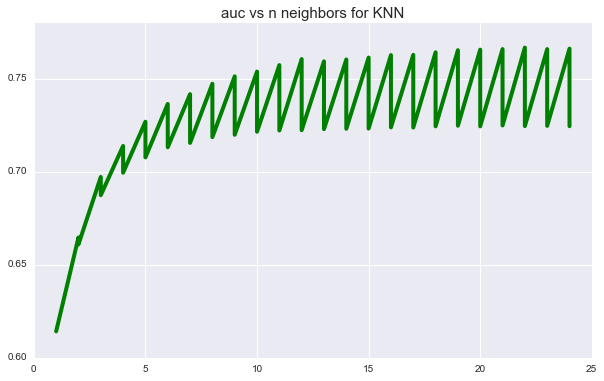

In [41]:
_, axs = plt.subplots(1, 1, figsize=(10, 6))
sns.set_style('darkgrid')
axs.plot(np.array([g[0]['n_neighbors'] for g in gs.grid_scores_]), [g[1] for g in gs.grid_scores_], color='green', linewidth=4.0)
axs.set_title('auc vs n neighbors for KNN', fontsize=15)
plt.show()

### Compare LR and KNN on full data set with best best hyperparameters found during CV

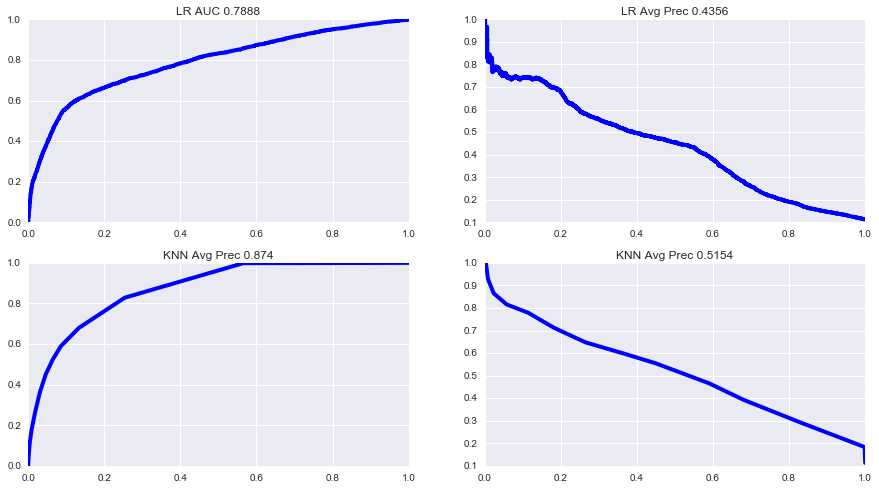

In [42]:
lr_model = lm.LogisticRegression(C=1, penalty='l2', fit_intercept=True)
knn_model = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform') #auc gain diminishes around 15

df_model = df[keep + ['y']]

df_model = get_dummies(df_model, [i for i in df_model.columns if df[i].dtype=='object'])

X, y = df_model[[c for c in df_model.columns if c!='y']], df_model.y

lr_model.fit(X, y)
knn_model.fit(X, y)

_, axs = plt.subplots(2, 2, figsize=(15, 8))
sns.set_style('darkgrid')

fpr, tpr, _ = roc_curve(y, lr_model.predict_proba(X)[:, -1])
axs[0,0].plot(fpr, tpr, color='blue', linewidth=4)
auc = roc_auc_score(y, lr_model.predict_proba(X)[:, -1])
axs[0,0].set_title('LR AUC %s'%round(auc, 4))
fpr, tpr, _ = roc_curve(y, knn_model.predict_proba(X)[:, -1])
axs[1,0].plot(fpr, tpr, color='blue', linewidth=4)
auc = roc_auc_score(y, knn_model.predict_proba(X)[:, -1])
axs[1,0].set_title('KNN Avg Prec %s'%round(auc, 4))

prec, rec, _ = precision_recall_curve(y, lr_model.predict_proba(X)[:, -1])
avg_prec = str(round(average_precision_score(y, lr_model.predict_proba(X)[:, -1]), 4))
axs[0,1].plot(rec, prec, color='blue', linewidth=4)
axs[0,1].set_title('LR Avg Prec %s'%avg_prec)
prec, rec, _ = precision_recall_curve(y, knn_model.predict_proba(X)[:, -1])
avg_prec = str(round(average_precision_score(y, knn_model.predict_proba(X)[:, -1]), 4))
axs[1,1].plot(rec, prec, color='blue', linewidth=4)
axs[1,1].set_title('KNN Avg Prec %s'%avg_prec)

plt.show()

In [43]:
lr_model.score(X, y)

0.89899970865300571

In [44]:
knn_model.score(X, y)

0.90094202194814021

    - KNN is better for prediction

## What does the Model tell us about our predictors?

In [45]:
odds = [np.exp(i) for i in lr_model.coef_[0]]
absv = [abs(i) for i in lr_model.coef_[0]]
pd.DataFrame(zip(X.columns.tolist(), list(lr_model.coef_[0]), odds, absv), columns=['feature', 'coef', 'odds', 'absv']).sort_values('absv', ascending=False).drop('absv', axis=1)

,feature,coef,odds
19,poutcome_success,1.834104,6.259522
13,month_mar,1.055378,2.873061
14,month_may,-0.704750,0.494232
18,poutcome_nonexistent,0.665726,1.945904
2,euribor3m,-0.483544,0.616594
10,month_dec,0.409064,1.505408
11,month_jul,0.379047,1.460892
5,working_retired,0.358757,1.431549
16,month_oct,0.335236,1.398271
6,working_student,0.321469,1.379152


    - If the previous marketing campaign was a success for this customer, the odds this customer will convert are over 6x higher than if the outcome of the previous campaign was a failure. About 3x higher than if it were unknown.
    - If the previous marketing campaign was a failure, you are half as likely to convert than if it was unknown (poutcome)
    - Calls in March convert great, calls in May convert terribly (month)
    - Retired and Student convert better than Unemployed or Working (working)
    - Contact on a House Phone is 25% less likely to conver than a Cell Phone (contact)
    - Wednesday is the best day to call the customer, Mon and Fri the worst (day_of_week)
    - The more calls made to this client before this campaign, the more likely they are to convert (previous)
    - The more calls made to this client during this campaign, the less likely they are to convert (campaign)

##  Use KNN to predict duration from Keep features

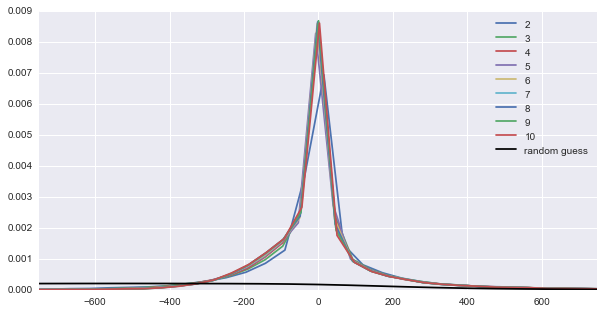

In [68]:
sns.set_palette('deep')
plt.figure(figsize=(10, 5))
X, y = X.copy(), df.duration
for n in range(2, 11):
    knnr = neighbors.KNeighborsRegressor(n_neighbors=n, weights='distance')
    errors = np.array(y) - np.array(knnr.fit(X, y).predict(X))
    sns.distplot(errors, hist=False, label=n)

errors = np.array(y) - np.random.randint(min(y), max(y), len(y))
sns.distplot(errors, hist=False, label='random guess', color='black')
plt.xlim(-750, 750)
plt.legend(loc='best')
plt.show()

    - Since duration and y are closely correlated, it might be better to use KNN to predict duration